# [LSTM] Time Series Forecasting household electric power consumption

### "[AUTHOR]: YASSINE SFAIHI"

# Introduction

This notebook is about time series forecasting of global active power consumption of a single household over a period of 4 years (2006-2010).


The dataset used for this notebook can be found at this UCI Machine Learning Repository link: "https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption".


The purpose of this notebook is to demonstrate the use of LSTM recurrent neural network in time series forecasting.


The steps involved in this notebook are as follows:

   1- Data pre-processing, including handling missing values and converting the data into a stationary time series.
     
   2-  Exploratory Data Analysis (EDA), including visualizing the time series to understand the pattern and trends.
   3- Data preparation for modeling, including splitting the data into training and testing datasets and transforming the data into a format that can be fed into the LSTM model.
    
   4- Building and training the LSTM model on the training data.
    
   5- Model evaluation, including calculating the mean absolute error and root mean squared error for both the training and testing datasets.
    
   6- Visualizing the training and testing loss over the epochs and plotting the actual vs. predicted global active power consumption.

In [1]:
# Import necessary libraries and packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Set floating point precision option for pandas
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Import seaborn library and set context and style
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')

# Import warnings and set filter to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Import time library
from time import time

# Import matplotlib ticker and scipy stats
import matplotlib.ticker as tkr
from scipy import stats

# Import statistical tools for time series analysis
from statsmodels.tsa.stattools import adfuller

# Import preprocessing from sklearn
from sklearn import preprocessing

# Import partial autocorrelation function from statsmodels
from statsmodels.tsa.stattools import pacf

# Enable inline plotting in Jupyter Notebook
%matplotlib inline

# Import math library
import math

# Import necessary functions from keras
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *

# Import MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Import mean squared error and mean absolute error from sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Import early stopping from keras callbacks
from keras.callbacks import EarlyStopping


2023-02-09 05:33:50.417089: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-09 05:33:50.417183: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Load the data from the file 'household_power_consumption.txt' using pandas
# and specify the delimiter as ';'
data = pd.read_csv('/home/yassine/Documents/portfolio/household_power_consumption.txt', delimiter=';')

In [3]:
# Print the number of rows and columns in the data
print('Number of rows and columns:', data.shape)

# Display the first 5 rows of the data
data.head(5)

Number of rows and columns: (2075259, 9)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0000


In [4]:
# Display the last 5 rows of the data
data.tail(5)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2075254,26/11/2010,20:58:00,0.9460,0.0000,240.4300,4.0000,0.0000,0.0000,0.0000
2075255,26/11/2010,20:59:00,0.9440,0.0000,240.0000,4.0000,0.0000,0.0000,0.0000
2075256,26/11/2010,21:00:00,0.9380,0.0000,239.8200,3.8000,0.0000,0.0000,0.0000
2075257,26/11/2010,21:01:00,0.9340,0.0000,239.7000,3.8000,0.0000,0.0000,0.0000
2075258,26/11/2010,21:02:00,0.9320,0.0000,239.5500,3.8000,0.0000,0.0000,0.0000


In [10]:
# Get the information about the dataframe
print("\nInformation about the dataframe:")
print(data.info())


Information about the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB
None


In [12]:
# Get the data type of each column in the dataframe
print("\nData type of each column in the dataframe:")
print(data.dtypes)


Data type of each column in the dataframe:
Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object


# FEATURE ENGINEERING

In [13]:
# Convert the 'Date' and 'Time' columns to a single 'date_time' column
# by combining the two columns and converting to datetime format
data['date_time'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])

In [14]:
# Convert the 'Global_active_power' column to numeric format
# and remove any rows with NaN values
data['Global_active_power'] = pd.to_numeric(data['Global_active_power'], errors='coerce')
data = data.dropna(subset=['Global_active_power'])

In [15]:

# Convert the 'date_time' column to datetime format
data['date_time'] = pd.to_datetime(data['date_time']) 

In [16]:
# Create new columns for year, quarter, month, and day
data['year'] = data['date_time'].apply(lambda x: x.year)
data['quarter'] = data['date_time'].apply(lambda x: x.quarter)
data['month'] = data['date_time'].apply(lambda x: x.month)
data['day'] = data['date_time'].apply(lambda x: x.day)

In [17]:
# Keep only the columns 'date_time', 'Global_active_power', 'year', 'quarter', 'month', 'day'
data = data.loc[:,['date_time','Global_active_power', 'year','quarter','month','day']]

In [18]:
# Sort the data by date_time in ascending order
data.sort_values('date_time', inplace=True, ascending=True)

In [19]:
# Reset the index of the data
data = data.reset_index(drop=True)


In [20]:
# Create a new column 'weekday' that indicates if the day is a weekday (1) or weekend (0)
data['weekday'] = data['date_time'].apply(lambda x: x.weekday() < 5).astype(int)

In [21]:
# Print the number of rows and columns in the data
print('Number of rows and columns:', data.shape)

# Print the minimum and maximum date_time values
print('Minimum date_time:', data.date_time.min())
print('Maximum date_time:', data.date_time.max())

# Display the last 5 rows of the data
data.tail(5)

Number of rows and columns: (2049280, 7)
Minimum date_time: 2006-12-16 17:24:00
Maximum date_time: 2010-12-11 23:59:00


,date_time,Global_active_power,year,quarter,month,day,weekday
2049275,2010-12-11 23:55:00,0.6900,2010,4,12,11,0
2049276,2010-12-11 23:56:00,0.6880,2010,4,12,11,0
2049277,2010-12-11 23:57:00,0.6880,2010,4,12,11,0
2049278,2010-12-11 23:58:00,0.6880,2010,4,12,11,0
2049279,2010-12-11 23:59:00,0.6880,2010,4,12,11,0


# Testing for Normality of the Global Active Power Data

Testing for Normality

We will use D’Agostino’s K^2 Test to determine if our data is normally distributed. In the SciPy implementation of the test, the p-value will be used to make the following interpretation:

    If p <= alpha, we will reject the null hypothesis (H0) and conclude that the data is not normally distributed.
    If p > alpha, we will fail to reject the null hypothesis and conclude that the data is normal.


In [ ]:
!pip install stats

In [25]:
# Test for Normality of the Global Active Power Data

# Import the required libraries
import scipy.stats as stats

# Calculate the test statistics and p-value
stat, p = stats.normaltest(data.Global_active_power)

# Print the results
print('Statistics=%.3f, p=%.3f' % (stat, p))

# Set the significance level
alpha = 0.05

# Make a decision on the test result
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')


Statistics=724881.795, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: 4.218671866132123
Skewness of normal distribution: 1.7862320846320832


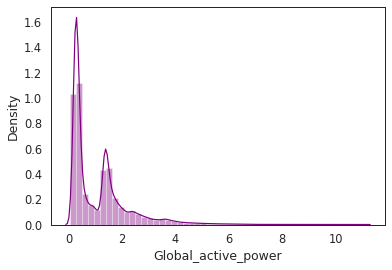

In [62]:
sns.distplot(data.Global_active_power,color='purple')
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(data.Global_active_power)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(data.Global_active_power)))


The kurtosis of a normal distribution is close to zero, and if the kurtosis is greater than zero, the distribution has heavier tails.

On the other hand, skewness measures the symmetry of the distribution. If the skewness is between -0.5 and 0.5, the data is considered fairly symmetrical.

However, if the skewness falls between -1 and -0.5 or between 0.5 and 1, the data is considered moderately skewed.

Lastly, if the skewness is less than -1 or greater than 1, the data is considered highly skewed. In this particular case, the skewness value is greater than 1, indicating a highly skewed distribution.

# Exploratory Data Analysis(EDA)

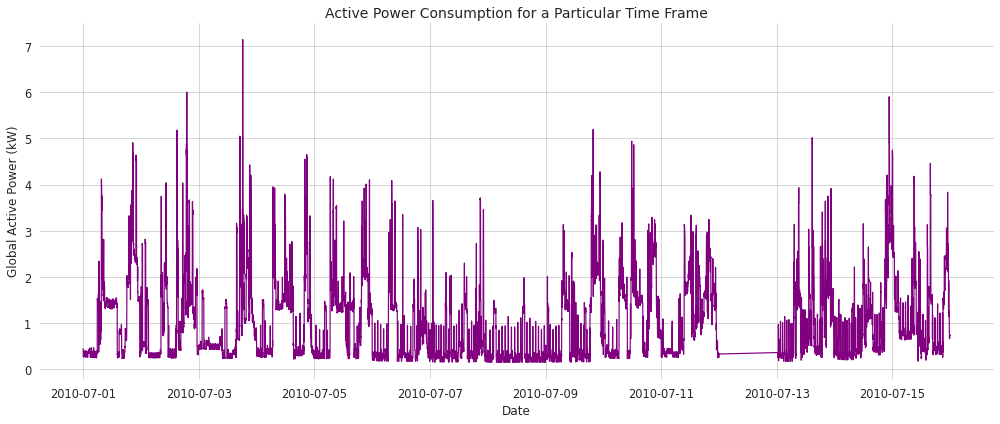

In [61]:
data1 = data[(data.date_time >= '2010-07-01') & (data.date_time < '2010-7-16')]

plt.figure(figsize=(14,6))
plt.plot(data1.date_time, data1.Global_active_power, color='purple')
plt.ylabel('Global Active Power (kW)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.title('Active Power Consumption for a Particular Time Frame', fontsize=14)
plt.tight_layout()
plt.grid(True)
sns.despine(bottom=True, left=True)
plt.show()


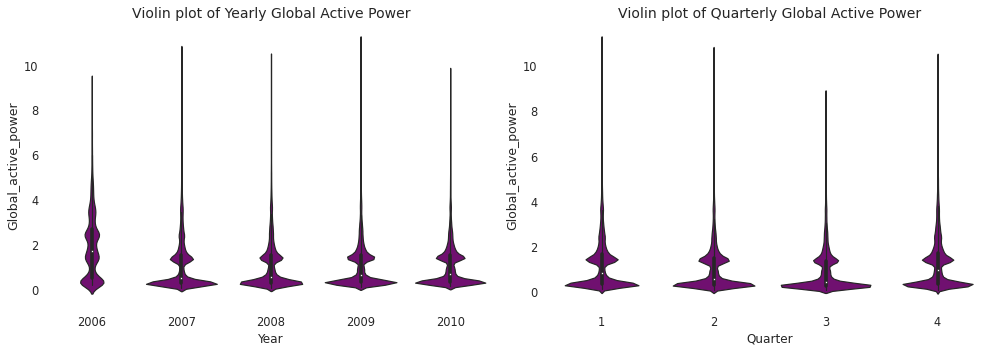

In [63]:
# Import required libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with 2 subplots
plt.figure(figsize=(14,5))

# Plot the first subplot showing the violinplot of yearly global active power
plt.subplot(1,2,1)
# Adjust the subplot's width
plt.subplots_adjust(wspace=0.2)
# Create the violinplot using Seaborn's violinplot function
sns.violinplot(x="year", y="Global_active_power", data=data, color='purple')
# Label the x-axis
plt.xlabel('Year', fontsize=12)
# Add a title to the plot
plt.title('Violin plot of Yearly Global Active Power', fontsize=14)
# Remove the top and right spines of the plot
sns.despine(left=True, bottom=True)
# Add a tight layout to the plot
plt.tight_layout() 

# Plot the second subplot showing the violinplot of quarterly global active power
plt.subplot(1,2,2)
# Create the violinplot using Seaborn's violinplot function
sns.violinplot(x="quarter", y="Global_active_power", data=data, color='purple')
# Label the x-axis
plt.xlabel('Quarter', fontsize=12)
# Add a title to the plot
plt.title('Violin plot of Quarterly Global Active Power', fontsize=14)
# Remove the top and right spines of the plot
sns.despine(left=True, bottom=True)
# Add a tight layout to the plot
plt.tight_layout()


When we compare violin plots side by side for each year, we notice that the median global active power in 2006 appears to be much higher than in other years. However, this observation may be misleading as we only have data for December of 2006, which is typically the highest month for household electricity consumption.

This pattern is also reflected in the quarterly median global active power, which is higher during the first and fourth quarters (winter) and lowest during the third quarter (summer).


                         count      mean    std       min       25%       50%  \
Global_active_power 20159.0000    0.9794 0.8599    0.1540    0.3320    0.5940   
year                20159.0000 2010.0000 0.0000 2010.0000 2010.0000 2010.0000   
quarter             20159.0000    3.0000 0.0000    3.0000    3.0000    3.0000   
month               20159.0000    7.0000 0.0000    7.0000    7.0000    7.0000   
day                 20159.0000    7.7139 4.3330    1.0000    4.0000    7.0000   
weekday             20159.0000    0.7143 0.4518    0.0000    0.0000    1.0000   

                          75%       max  
Global_active_power    1.4340    7.1400  
year                2010.0000 2010.0000  
quarter                3.0000    3.0000  
month                  7.0000    7.0000  
day                   11.0000   15.0000  
weekday                1.0000    1.0000  


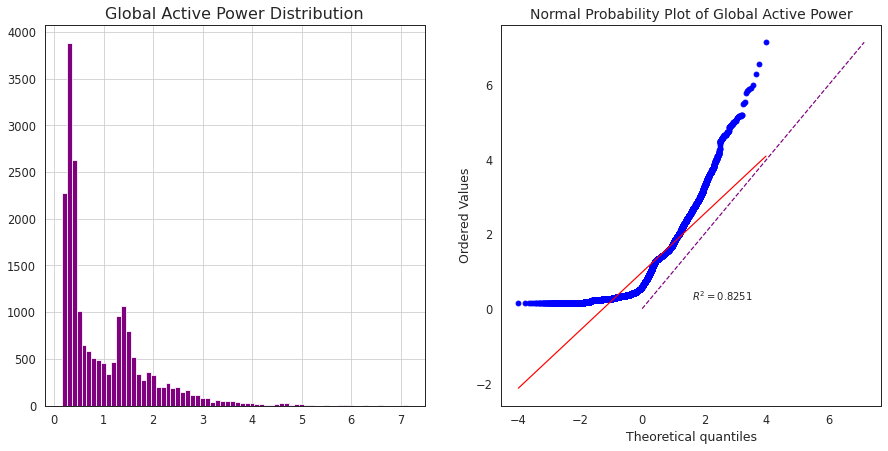

In [70]:
# Plotting the histogram and normal probability plot for 'Global_active_power' column
plt.figure(figsize=(15,7))

# Histogram of 'Global_active_power' column
plt.subplot(1,2,1)
data1['Global_active_power'].hist(bins=70, color='purple')
plt.title('Global Active Power Distribution', fontsize=16)

# Normal Probability Plot of 'Global_active_power' column
plt.subplot(1,2,2)
# Create the normal probability plot using stats.probplot
stats.probplot(data1['Global_active_power'], plot=plt, fit=True, rvalue=True)
# Add a line to the plot
plt.plot([0, max(data1['Global_active_power'])], [0, max(data1['Global_active_power'])], color='purple', linestyle='--')
plt.title('Normal Probability Plot of Global Active Power', fontsize=14)


# Printing the summary statistics of 'Global_active_power' column
print(data1.describe().T)



The normal probability plot demonstrates that the data is significantly deviating from a normal distribution.

In [72]:
data1=data.loc[:,['date_time','Global_active_power']]
data1.set_index('date_time',inplace=True)

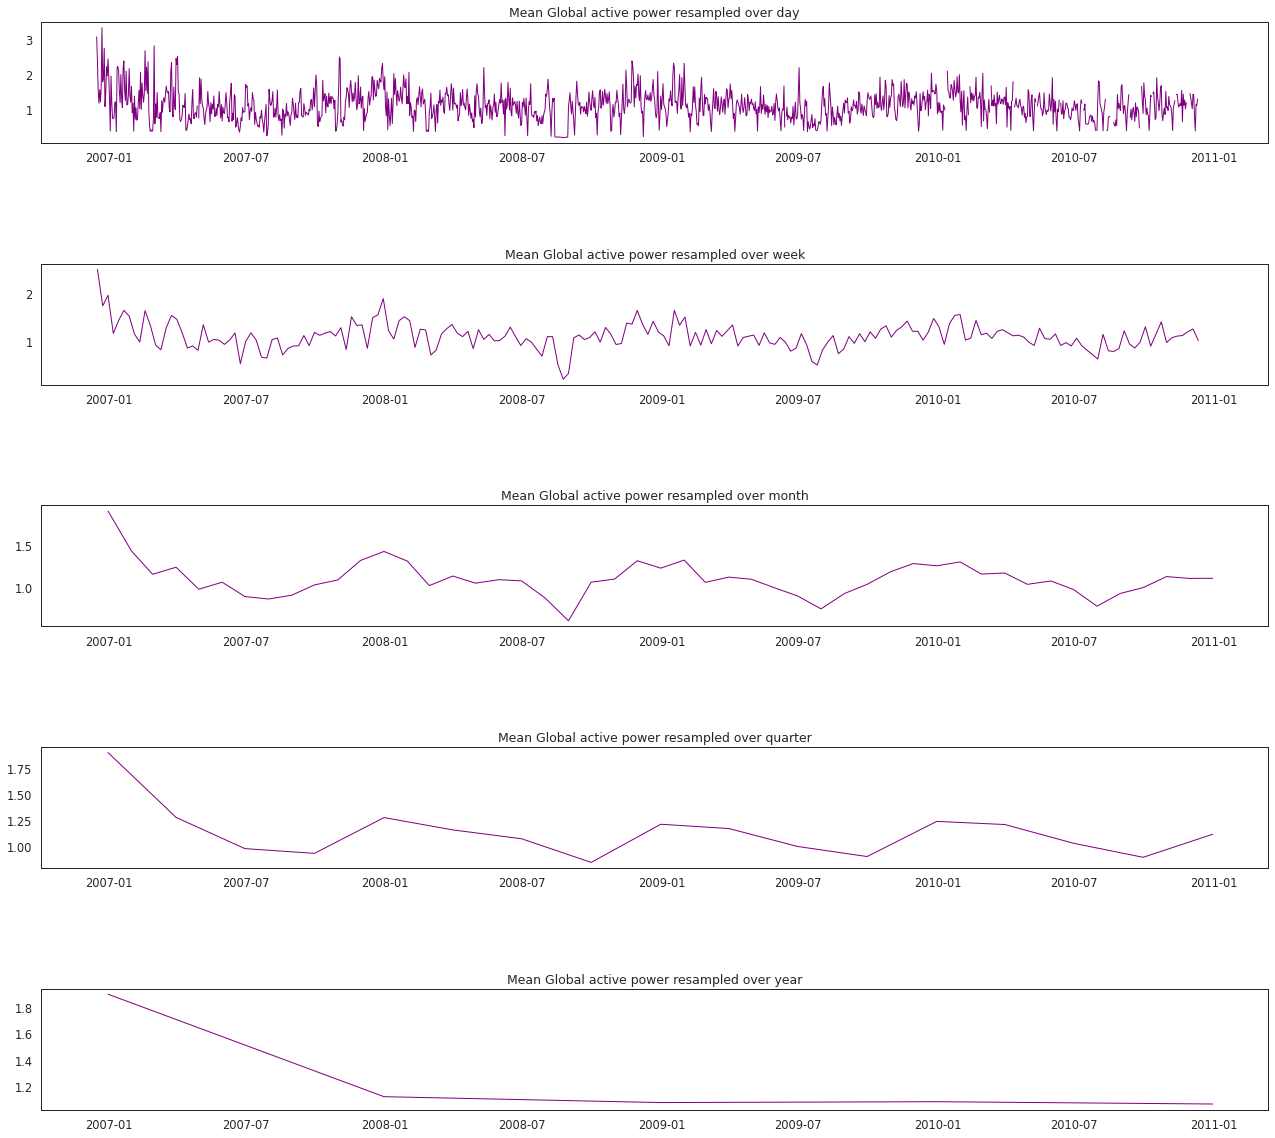

In [76]:
# Create a figure with specified size
fig = plt.figure(figsize=(22,20))
# Adjust the subplot spacing
fig.subplots_adjust(hspace=1)

# Create first subplot
ax1 = fig.add_subplot(5,1,1)
# Plot the resampled mean of Global_active_power over day with different color
ax1.plot(data1['Global_active_power'].resample('D').mean(), linewidth=1, color='purple')
# Set the title for the subplot
ax1.set_title('Mean Global active power resampled over day')
# Set major tick parameters for the subplot
ax1.tick_params(axis='both', which='major')

# Create second subplot
ax2 = fig.add_subplot(5,1,2, sharex=ax1)
# Plot the resampled mean of Global_active_power over week with different color
ax2.plot(data1['Global_active_power'].resample('W').mean(), linewidth=1, color='purple')
# Set the title for the subplot
ax2.set_title('Mean Global active power resampled over week')
# Set major tick parameters for the subplot
ax2.tick_params(axis='both', which='major')

# Create third subplot
ax3 = fig.add_subplot(5,1,3, sharex=ax1)
# Plot the resampled mean of Global_active_power over month with different color
ax3.plot(data1['Global_active_power'].resample('M').mean(), linewidth=1, color='purple')
# Set the title for the subplot
ax3.set_title('Mean Global active power resampled over month')
# Set major tick parameters for the subplot
ax3.tick_params(axis='both', which='major')

# Create third subplot
ax4  = fig.add_subplot(5,1,4, sharex=ax1)
# Plot the resampled mean of Global_active_power over month with different color
ax4.plot(data1['Global_active_power'].resample('Q').mean(),linewidth=1, color='purple')
# Set the title for the subplot
ax4.set_title('Mean Global active power resampled over quarter')
# Set major tick parameters for the subplot
ax4.tick_params(axis='both', which='major')


# Create third subplot
ax5  = fig.add_subplot(5,1,5, sharex=ax1)
# Plot the resampled mean of Global_active_power over month with different color
ax5.plot(data1['Global_active_power'].resample('A').mean(),linewidth=1, color='purple')
# Set the title for the subplot
ax5.set_title('Mean Global active power resampled over year')
# Set major tick parameters for the subplot
ax5.tick_params(axis='both', which='major')



The overall trend in our time series data does not show a consistent increase or decrease.

The peak average power consumption was observed prior to 2007, but then there was a noticeable drop in 2008 and it has remained relatively stable since then.

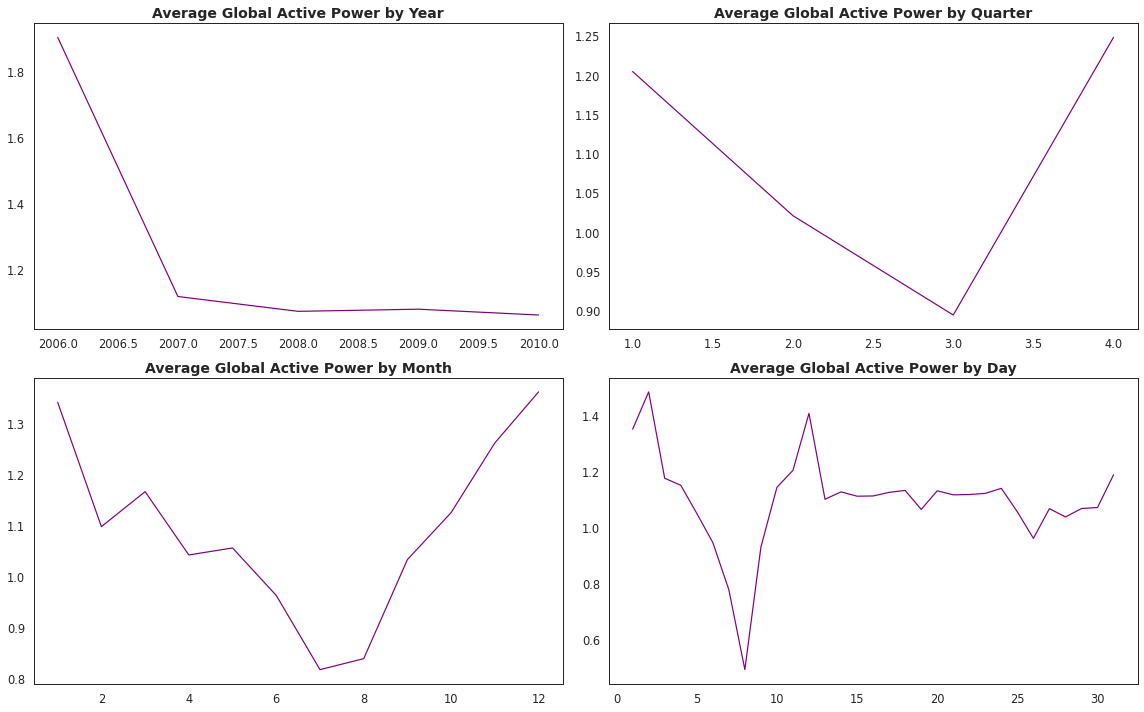

In [81]:
# Import the matplotlib library for plotting graphs
import matplotlib.pyplot as plt

# Create a figure with 2 rows and 2 columns and set its size to 14x8
plt.figure(figsize=(16,10))

# First subplot in the first row, first column
plt.subplot(2,2,1)
# Group data by year and take the mean of the 'Global_active_power' column
grouped_by_year = data.groupby('year').Global_active_power.agg('mean')
# Plot the mean of 'Global_active_power' by year with red color
grouped_by_year.plot(color='purple')
# Set the x label to be empty
plt.xlabel('')
# Set the title to 'Average Global Active Power by Year' with font size 12 and font weight 'bold'
plt.title('Average Global Active Power by Year', fontsize=14, fontweight='bold')

# Second subplot in the first row, second column
plt.subplot(2,2,2)
# Group data by quarter and take the mean of the 'Global_active_power' column
grouped_by_quarter = data.groupby('quarter').Global_active_power.agg('mean')
# Plot the mean of 'Global_active_power' by quarter with blue color
grouped_by_quarter.plot(color='purple')
# Set the x label to be empty
plt.xlabel('')
# Set the title to 'Average Global Active Power by Quarter' with font size 12 and font weight 'bold'
plt.title('Average Global Active Power by Quarter', fontsize=14, fontweight='bold')

# Third subplot in the second row, first column
plt.subplot(2,2,3)
# Group data by month and take the mean of the 'Global_active_power' column
grouped_by_month = data.groupby('month').Global_active_power.agg('mean')
# Plot the mean of 'Global_active_power' by month with purple color
grouped_by_month.plot(color='purple')
# Set the x label to be empty
plt.xlabel('')
# Set the title to 'Average Global Active Power by Month' with font size 12 and font weight 'bold'
plt.title('Average Global Active Power by Month', fontsize=14, fontweight='bold')

# Fourth subplot in the second row, second column
plt.subplot(2,2,4)
# Group data by day and take the mean of the 'Global_active_power' column
grouped_by_day = data.groupby('day').Global_active_power.agg('mean')
# Plot the mean of 'Global_active_power' by day with green color
grouped_by_day.plot(color='purple')
# Set the x label to be empty
plt.xlabel('')
# Set the title to 'Average Global Active Power by Day' with font size 12 and font weight 'bold'
plt.title('Average Global Active Power by Day', fontsize=14, fontweight='bold')

# Use tight_layout to adjust the subplots so that they fit into the figure area
plt.tight_layout()

# Show the plot
plt.show()



The visualization of the data has reinforced our previous observations.

We observed that the average power consumption was the highest prior to 2007, and it has remained consistent since then. We also found that the lowest average power consumption was recorded in the third quarter. 

Additionally, the months of July and August recorded the lowest average power consumption, and the lowest daily average was recorded around the 8th of the month (the reason for this is unknown

# Dickey-Fuller test  statistical test to determine the stationarity of a time series

The Dickey-Fuller test is used to test the null hypothesis that a unit root is present in a time series, which means it is non-stationary and has some time-dependent structure. 
On the other hand, the alternative hypothesis is that the time series does not have a unit root, meaning it is stationary and does not have time-dependent structure.


In the Dickey-Fuller test, if the p-value is greater than 0.05, it means we accept the null hypothesis and the data is considered to be non-stationary. However, if the p-value is less than or equal to 0.05, we reject the null hypothesis and the data is considered to be stationary.


While LSTM models do not require stationarity of the data, a stationary series with constant mean and variance over time can result in better performance and make it easier for the neural network to learn.

In [90]:
def test_stationarity(timeseries):
    # Calculate rolling mean and standard deviation
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    # Plot original timeseries, rolling mean, and rolling standard deviation
    plt.figure(figsize=(20,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='purple',label='Original')
    mean = plt.plot(rolmean, color='yellow', label='Rolling Mean')
    std = plt.plot(rolstd, color='cyan', label = 'Rolling Std')

    # Add legend
    plt.legend(loc='best')
    # Add title
    plt.title('Rolling Mean & Standard Deviation of Global Active Power')
    plt.show()

    # Perform and display results of Dickey-Fuller test
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                     index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)



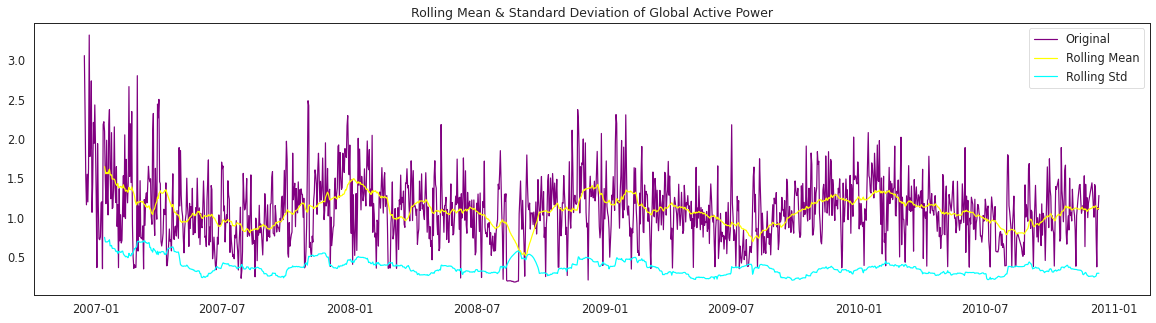

<Results of Dickey-Fuller Test>
Test Statistic                  -8.3277
p-value                          0.0000
#Lags Used                       9.0000
Number of Observations Used   1423.0000
Critical Value (1%)             -3.4350
Critical Value (5%)             -2.8636
Critical Value (10%)            -2.5679
dtype: float64


In [91]:
test_stationarity(data2.Global_active_power.dropna())

The null hypothesis, which suggests the presence of a unit root and therefore non-stationarity in the time series, can be rejected based on the results of the Dickey-Fuller test.

This implies that the data does not have a time-dependent structure and is stationary.

In this task, the goal is to predict the power consumption of a household for a time series, based on the history of 2 million minutes of consumption data.

To accomplish this, we will use a multi-layer LSTM recurrent neural network. To ensure that the model provides an accurate prediction, the data will be kept at its original minute-level resolution, instead of being resampled to a lower frequency such as hours.

# Modelling and Evaluation

In [96]:
#Transform the Global_active_power column of the data DataFrame into a numpy array of float values

dataset = data.Global_active_power.values.astype('float32')
#Reshape the numpy array into a 2D array with 1 column

dataset = np.reshape(dataset, (-1, 1))
#Create an instance of the MinMaxScaler class to scale the values between 0 and 1

scaler = MinMaxScaler(feature_range=(0, 1))
#Fit the MinMaxScaler to the transformed data and transform the values

dataset = scaler.fit_transform(dataset)
#Split the transformed data into a training set (80%) and a test set (20%)

train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [97]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)


In [98]:
# reshape into X=t and Y=t+1
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [99]:
X_train.shape

(1639393, 30)

In [100]:
Y_train.shape

(1639393,)

In [101]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [102]:
X_train.shape

(1639393, 1, 30)

# LSTM model

In [104]:
# Defining the LSTM model
model = Sequential()

# Adding the first layer with 100 LSTM units and input shape of the data
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))

# Adding a dropout layer to avoid overfitting
model.add(Dropout(0.2))

# Adding a dense layer with 1 unit to make predictions
model.add(Dense(1))

# Compiling the model with mean squared error as the loss function and using Adam optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

# Fitting the model on training data and using early stopping to avoid overfitting
history = model.fit(X_train, Y_train, epochs=20, batch_size=1240, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=4)], verbose=1, shuffle=False)

# Displaying a summary of the model
model.summary()


Epoch 1/20
1323/1323 [==============================] - 26s 18ms/step - loss: 0.0011 - val_loss: 4.1580e-04
Epoch 2/20
1323/1323 [==============================] - 31s 24ms/step - loss: 6.5898e-04 - val_loss: 4.1012e-04
Epoch 3/20
1323/1323 [==============================] - 46s 35ms/step - loss: 6.4859e-04 - val_loss: 4.0140e-04
Epoch 4/20
1323/1323 [==============================] - 58s 44ms/step - loss: 6.3604e-04 - val_loss: 4.1103e-04
Epoch 5/20
1323/1323 [==============================] - 58s 44ms/step - loss: 6.3291e-04 - val_loss: 4.0959e-04
Epoch 6/20
1323/1323 [==============================] - 59s 44ms/step - loss: 6.3009e-04 - val_loss: 4.0303e-04
Epoch 7/20
1323/1323 [==============================] - 48s 36ms/step - loss: 6.2654e-04 - val_loss: 4.0651e-04
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100)               52400     


# Evaluation

In [105]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 0.10347279920086673
Train Root Mean Squared Error: 0.2696353979332258
Test Mean Absolute Error: 0.09029906112109547
Test Root Mean Squared Error: 0.22271064457180156


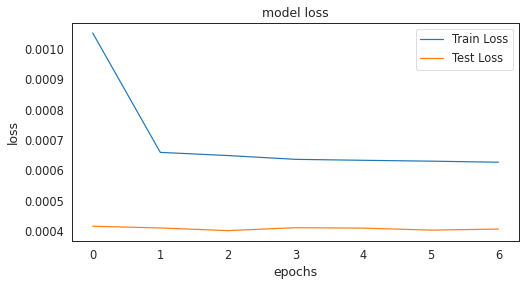

In [106]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

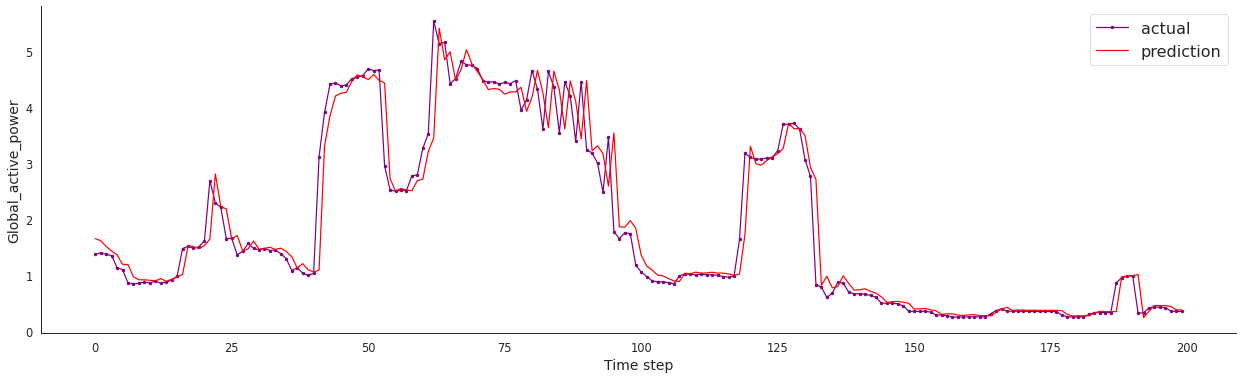

In [107]:
aa=[x for x in range(200)]
# Creating a figure object with desired figure size
plt.figure(figsize=(20,6))

# Plotting the actual values in blue with a dot marker
plt.plot(aa, Y_test[0][:200], marker='.', label="actual", color='purple')

# Plotting the predicted values in green with a solid line
plt.plot(aa, test_predict[:,0][:200], '-', label="prediction", color='red')

# Removing the top spines
sns.despine(top=True)

# Adjusting the subplot location
plt.subplots_adjust(left=0.07)

# Labeling the y-axis
plt.ylabel('Global_active_power', size=14)

# Labeling the x-axis
plt.xlabel('Time step', size=14)

# Adding a legend with font size of 15
plt.legend(fontsize=16)

# Display the plot
plt.show()


# summary

In summary, this notebook provides a complete example of how to use a deep learning model to make predictions based on time series data. The model's performance is evaluated using various metrics, and the results are visualized to provide a clear understanding of how well the model is able to make predictions.